In [23]:
import re
from string import punctuation

import pandas as pd
import time
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import PassiveAggressiveClassifier

In [15]:
#Install the requirements
! pip install --upgrade pip
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 591.5 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.11.4
    Uninstalling tokenizers-0.11.4:
      Successfully uninstalled tokenizers-0.11.4


In [4]:
#Text cleaning function
def text_cleaning(text, remove_stop_words=True, lemmatize_words=True):
    # Clean the text, with the option to remove stop_words and to lemmatize word
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"http\S+", " link ", text)
    text = re.sub(r"\b\d+(?:\.\d+)?\s+", "", text)  # remove numbers
    
    # Remove punctuation from text
    text = "".join([c for c in text if c not in punctuation])
    
    # Optionally, remove stop words
    if remove_stop_words:
        # load stopwords
        stop_words = stopwords.words("english")
        text = text.split()
        text = [w for w in text if not w in stop_words]
        text = " ".join(text)
        
    # Optionally, shorten words to their stems
    if lemmatize_words:
        text = text.split()
        lemmatizer = WordNetLemmatizer()
        lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
        text = " ".join(lemmatized_words)
        
    # Return a list of words
    return text

In [5]:
def cosineSimillarity(corpus):
    
    start = time.time()
    # Initialize an instance of tf-idf Vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Generate the tf-idf vectors for the corpus
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

    # compute and print the cosine similarity matrix
    #cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
    #print(cosine_sim)
    # Print time taken
    print("Time taken: %s seconds" % (time.time() - start))
    return cosine_sim

In [6]:
#Convert pandas series into dictionary
def convertPdToDict(pandaSeries):
    return pandaSeries.to_dict()

In [7]:
#Read the train dataset
train_df = pd.read_csv("./data/train.csv")
display(train_df)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [8]:
# Clean the dataset 
train_copy_df = train_df.copy()

train_copy_df["text"] = train_copy_df["text"].apply(lambda text:text_cleaning(text))
display(train_copy_df)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds Reason earthquake May ALLAH Forgive u,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All resident asked shelter place notified offi...,1
3,6,NaN,NaN,people receive wildfire evacuation order Calif...,1
4,7,NaN,NaN,Just got sent photo Ruby Alaska smoke wildfire...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant crane holding bridge collapse nearby...,1
7609,10870,NaN,NaN,aria ahrary TheTawniest The control wild fire ...,1
7610,10871,NaN,NaN,M1 UTC 5km S Volcano Hawaii http co zDtoyd8EbJ,1
7611,10872,NaN,NaN,Police investigating e bike collided car Littl...,1


In [16]:
#Do the text classification using cosine Similarity
cosine_sim = cosineSimillarity(train_copy_df["text"])

Time taken: 1.8822739124298096 seconds


array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.00840494],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00840494, 0.        ,
        1.        ]])

In [31]:
from sklearn.metrics import classification_report


def get_accuracy(y_pred_proba,y_test, y_pred, model_name):
    print(f"{model_name}:")
    print(accuracy_score(y_test, y_pred))
    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report")
    print(classification_report(y_test, y_pred))
    print("ROC Curve")
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("*"*50)

In [38]:
#Train the model to predict the target
#Split the dataset into train and test
from sklearn.model_selection import train_test_split
X = train_copy_df["text"]
y = train_copy_df["target"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
# Use the tf-idf vectorizer to vectorize the training set
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)



In [25]:

# Initialize the PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train, y_train)
# make predictions on the test set
y_pred = pac.predict(tfidf_test)
#compute the accuracy with accuracy_score()
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score*100,2)}%')



Accuracy: 75.97%


Accuracy: 79.71%


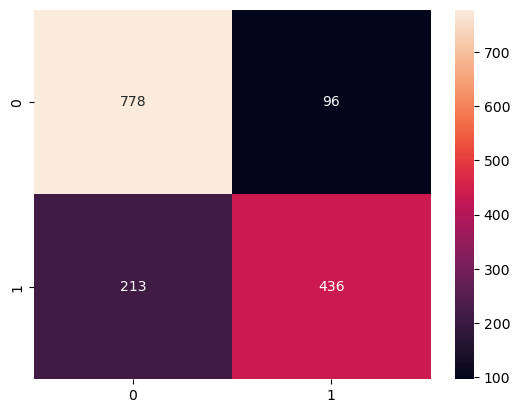

Support Vector Machine:
0.7971109652002626
Confusion Matrix
[[778  96]
 [213 436]]
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.83       874
           1       0.82      0.67      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523

ROC Curve


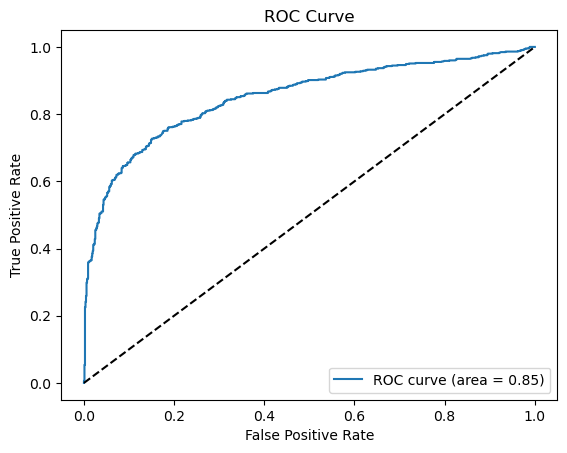

**************************************************


In [36]:
# Use SVM to make classification
from sklearn.svm import SVC
svc = SVC(probability=True)
svc.fit(tfidf_train, y_train)
# make predictions on the test set
y_pred = svc.predict(tfidf_test)
#compute the accuracy with accuracy_score()
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score*100,2)}%')
# plot the confusion matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()
# Display the ROC curve
# predict probabilities
probs = svc.predict_proba(tfidf_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
y_pred_proba = svc.predict_proba(tfidf_test)[:,1]
get_accuracy(y_pred_proba,y_test, y_pred, "Support Vector Machine")


In [11]:
# Use Naive Bayes to make classification
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(tfidf_train, y_train)
# make predictions on the test set
y_pred = nb.predict(tfidf_test)
#compute the accuracy with accuracy_score()
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score*100,2)}%')


Accuracy: 78.99%


In [12]:
# Use Logistic Regression to make classification
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(tfidf_train, y_train)
# make predictions on the test set
y_pred = lr.predict(tfidf_test)
#compute the accuracy with accuracy_score()
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score*100,2)}%')


Accuracy: 79.25%


In [13]:
# Use Random Forest to make classification
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(tfidf_train, y_train)
# make predictions on the test set
y_pred = rf.predict(tfidf_test)
#compute the accuracy with accuracy_score()
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score*100,2)}%')


Accuracy: 78.79%


In [14]:
# Use KNN to make classification
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(tfidf_train, y_train)
# make predictions on the test set
y_pred = knn.predict(tfidf_test)
#compute the accuracy with accuracy_score()
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 77.22%


In [15]:
# Use Decision Tree to make classification
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(tfidf_train, y_train)
# make predictions on the test set
y_pred = dt.predict(tfidf_test)
#compute the accuracy with accuracy_score()
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 70.91%


In [17]:
# Neural Network to make classification
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier()
nn.fit(tfidf_train, y_train)
# make predictions on the test set
y_pred = nn.predict(tfidf_test)
#compute the accuracy with accuracy_score()
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score*100,2)}%')


Accuracy: 75.44%


Iteration 1, loss = 0.69674261
Iteration 2, loss = 0.69116597
Iteration 3, loss = 0.68766573
Iteration 4, loss = 0.68572434
Iteration 5, loss = 0.68473094
Iteration 6, loss = 0.68418082
Iteration 7, loss = 0.68385799
Iteration 8, loss = 0.68369858
Iteration 9, loss = 0.68357708
Iteration 10, loss = 0.68350425
Iteration 11, loss = 0.68347981
Iteration 12, loss = 0.68345643
Iteration 13, loss = 0.68341927
Iteration 14, loss = 0.68341059
Iteration 15, loss = 0.68339529
Iteration 16, loss = 0.68336250
Iteration 17, loss = 0.68334093
Iteration 18, loss = 0.68332067
Iteration 19, loss = 0.68329903
Iteration 20, loss = 0.68328602
Iteration 21, loss = 0.68327909
Iteration 22, loss = 0.68325166
Iteration 23, loss = 0.68322555
Iteration 24, loss = 0.68320543
Iteration 25, loss = 0.68320163
Iteration 26, loss = 0.68317563
Iteration 27, loss = 0.68318032
Iteration 28, loss = 0.68313985
Iteration 29, loss = 0.68311207
Iteration 30, loss = 0.68308816
Iteration 31, loss = 0.68306592
Iteration 32, los

/Users/claudekwizera/anaconda3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,Actual,Predicted
2644,1,0
2227,0,0
5448,1,1
132,0,0
6845,0,0
...,...,...
1835,0,0
506,1,1
3592,1,1
6740,1,1


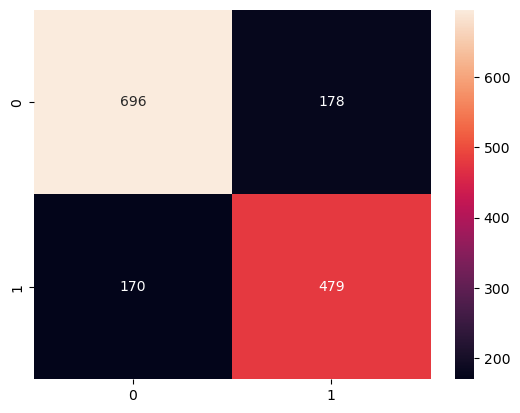

AUC: 0.840


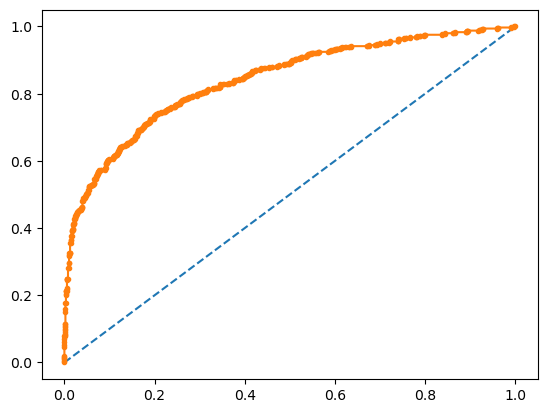

Accuracy: 77.15%


In [18]:
#Use Neural Network to make classification with different parameters and epochs and layers
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=500, alpha=0.0001,
                     solver='sgd', verbose=10,  random_state=21,tol=0.000000001)
nn.fit(tfidf_train, y_train)
# make predictions on the test set
y_pred = nn.predict(tfidf_test)
# Display predictions vs actual values in a dataframe
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
display(df)

#Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()
# Display the ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# predict probabilities
probs = nn.predict_proba(tfidf_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()


#compute the accuracy with accuracy_score()
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score*100,2)}%')

In [19]:
#Read the test dataset
test_df = pd.read_csv("./data/test.csv")
display(test_df)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [20]:
# Clean the dataset
test_copy_df = test_df.copy()
test_copy_df["text"] = test_copy_df["text"].apply(lambda text:text_cleaning(text))
display(test_copy_df)

,id,keyword,location,text
0,0,NaN,NaN,Just happened terrible car crash
1,2,NaN,NaN,Heard earthquake different city stay safe ever...
2,3,NaN,NaN,forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,Apocalypse lighting Spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kill China Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES SAFETY FASTENERS...
3259,10865,NaN,NaN,Storm RI worse last hurricane My city amp 3oth...
3260,10868,NaN,NaN,Green Line derailment Chicago http co UtbXLcBIuY
3261,10874,NaN,NaN,MEG issue Hazardous Weather Outlook HWO http c...


In [39]:

tfidf_test = tfidf_vectorizer.transform(test_copy_df["text"])
#Make predictions on the test set using SVM model
y_pred = svc.predict(tfidf_test)
# Save the predictions in a dataframe and write it to a csv file for submission
df = pd.DataFrame({'id': test_copy_df["id"], 'target': y_pred})
df.to_csv("./data/submission.csv", index=False)
display(df)


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1
